***
## Table of Contents
<br>
    <ol><h2><a href='#0' style="text-decoration : none; color : #000000;">1. Loading and Cleaning Data </a></h2> </ol>
    <br>
    <ol>
        <h2><a href='#1' style="text-decoration : none; color : #000000;">2. Initial Models</a></h2>
        <ul>
            <a href='#1.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#1.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br> 

<ol>
        <h2><a href='#2' style="text-decoration : none; color : #000000;">3. Feature Transformation with feature selection </a></h2>
        <ul>
            <a href='#2.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#2.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#3' style="text-decoration : none; color : #000000;">4. Feature Transformation with PCA</a></h2>
        <ul>
            <a href='#3.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#3.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#4' style="text-decoration : none; color : #000000;">5.Over Sampling</a></h2>
        <ul>
            <a href='#4.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#4.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
     
 <ol>
        <h2><a href='#5' style="text-decoration : none; color : #000000;">6.Under Sampling</a></h2>
        <ul>
            <a href='#5.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#5.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>

In [37]:
import pandas as pd
import numpy as np
import os
import json
from pandas.io.json import json_normalize
from IPython.display import display,clear_output,HTML
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from tabulate import tabulate

import keras
from keras.layers import Dense,Dropout
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier

import researchpy as rp

%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',305)

from sklearn.feature_selection import SelectKBest,chi2,RFE,RFECV,f_regression,SelectFromModel
from sklearn.linear_model import LogisticRegression,RandomizedLasso,LinearRegression, Ridge,Lasso
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,BaggingClassifier,VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold,GridSearchCV,train_test_split,cross_val_score

from sklearn.preprocessing import MinMaxScaler,StandardScaler,binarize
from sklearn.ensemble import RandomForestRegressor
# from minepy import MINE
from sklearn import metrics

import warnings
warnings.simplefilter("ignore", DeprecationWarning)

from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score,auc,roc_curve,recall_score,precision_score
from sklearn import metrics
from pandas_ml import ConfusionMatrix


from imblearn.over_sampling import SMOTE

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

import featuretools as ft

from scipy import stats

from statsmodels.stats.outliers_influence import variance_inflation_factor

In [38]:
### Function to plot Feature Importance
def feat_impt_plot(feat_impt,y_labels,width_s=1000,height_s=1000):
    
    m=pd.DataFrame(y_labels,feat_impt).reset_index()
    m.columns=['Feature_Importance','Features']
    m.sort_values(by='Feature_Importance',inplace=True,ascending=False)
    m['Features']=m['Features'].str.replace("dom_function_","")
    m['Features']=m['Features'].str.replace("js_function_","")
    m['Features']=m['Features'].apply(lambda x: str(x).lstrip('.'))
    m['Features']=m['Features'].str.replace("(","")
    
    data = [go.Bar(x=m.Feature_Importance.values,y=m.Features.values,text=np.round(m.Feature_Importance,4),
            textposition = 'outside',
            marker=dict(
                color='rgb(158,202,225)',
                line=dict(
                    color='rgb(8,48,107)',
                    width=1.5),
            ),
            opacity=0.6,
            orientation='h'
        )]
    layout = go.Layout(autosize=False,
    width=width_s,
    height=height_s,
    xaxis=dict(title='Feature Importances',
        tickfont=dict(
            size=12,
            color='black'
        )),
    yaxis=dict(automargin=True))
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

    
def check_cat(data):
    cat_var=[]
    num_var=[]
    for col in data.columns:
        if col!='Target':
            if len(data[col].value_counts())==2:
                cat_var.append(col)
            else:
                num_var.append(col)
    return cat_var,num_var


def num_stats(data,columns):
    lst=[]
    for col in columns:
        corr=stats.pointbiserialr(data[col],data.Target)[0]
        corr_p=stats.pointbiserialr(data[col],data.Target)[1]
        ttest=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[0]
        ttest_p=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[1]
        lst.append((corr,corr_p,ttest,ttest_p,col))
    stats_data=pd.DataFrame(lst,columns=['Pt. Biserial Corr','Pt. Biserial Corr p-val','ttest','ttest p-val','Feature'])
    stats_data.set_index('Feature',drop=True,inplace=True)
    stats_data.sort_values(by='ttest',inplace=True)
    del lst
    return stats_data


### Generate statistics for categorical data
def cat_stats(data,columns):
    lst=[]
    for col in columns:
        if col!='Target':
            table, results = rp.crosstab(data['Target'], data[col], prop= 'col', test= 'chi-square')
            x=results['results'].values.tolist()
            x.append(col)
            lst.append(x)
    chi_df=pd.DataFrame(lst,columns=['Pearson Chi-square','p-value','Cramers V','Feature'])
    chi_df.set_index('Feature',drop=True,inplace=True)
    chi_df.sort_values(by='Cramers V',ascending=False,inplace=True)
    del lst
    return chi_df

In [39]:
def KNN_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'K-Nearest Neighbors' + '\033[0m')
    knn=KNeighborsClassifier()
    knn.fit(X_train,Y_train)
    
    y_pred_train=knn.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the KNN model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=knn.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the KNN model for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    
    return knn,cm_train,cm_test,acc_train,acc_test,roc_auc

In [40]:
def Logistic_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Logistic Regression' + '\033[0m')
    log=LogisticRegression()
    log.fit(X_train,Y_train)
    
    y_pred_train=log.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the Logistic Regression model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=log.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the Logistic Regression model for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    
    return log,cm_train,cm_test,acc_train,acc_test,roc_auc

In [41]:
def RandomForest(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'RandomForest Classifier' + '\033[0m')
    rf=RandomForestClassifier()
    rf.fit(X_train,Y_train)
    
    y_pred_train=rf.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the Random Forest Classifier model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=rf.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the Random Forest Classifier for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    feat_impt_plot(rf.feature_importances_,feat)
    return rf,cm_train,cm_test,acc_train,acc_test,roc_auc,rf.feature_importances_

In [42]:
def AdaBoost(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'Adaoost Classifier' + '\033[0m')
    ada=AdaBoostClassifier()
    ada.fit(X_train,Y_train)
    
    y_pred_train=ada.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the Ada Boost Classifier model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=ada.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the Ada Boost Classifier for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    feat_impt_plot(ada.feature_importances_,feat)
    return ada,cm_train,cm_test,acc_train,acc_test,roc_auc,ada.feature_importances_

In [43]:
def GradientBoosting(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'GradientBoosting Classifier' + '\033[0m')
    gbc=GradientBoostingClassifier()
    gbc.fit(X_train,Y_train)
    
    y_pred_train=gbc.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the Gradient Boosting Classifier model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=gbc.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the Gradient Boosting Classifier for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    feat_impt_plot(gbc.feature_importances_,feat)
    return gbc,cm_train,cm_test,acc_train,acc_test,roc_auc,gbc.feature_importances_

In [44]:
def ExtraTree(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'ExtraTree Classifier' + '\033[0m')
    ext_tree=ExtraTreesClassifier()
    ext_tree.fit(X_train,Y_train)
    
    y_pred_train=ext_tree.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the Extra Tree Classifier model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=ext_tree.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the Extra Tree Classifier for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    feat_impt_plot(ext_tree.feature_importances_,feat)
    return ext_tree,cm_train,cm_test,acc_train,acc_test,roc_auc,ext_tree.feature_importances_

In [45]:
def Bagging(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Bagging Classifier' + '\033[0m')
    bagging=BaggingClassifier()
    bagging.fit(X_train,Y_train)
    
    y_pred_train=bagging.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the Bagging model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=bagging.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the Bagging model for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    
    return bagging,cm_train,cm_test,acc_train,acc_test,roc_auc

In [46]:
def DeepLearning1(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Neural Network-1' + '\033[0m')
    np.random.seed(0)
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=X_train.shape[1]))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)
    acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
    print("The accuracy of the model on training data is:",acc_train)
    cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
    cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
    display(cm_train)
    acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    print("The accuracy of the model on test data is:",acc_test)
    display(cm_test)
    return  deep_learning,cm_train,cm_test,acc_train,acc_test,roc_auc

### <a id='0' style="text-decoration : none; color : #000000;"> 1. Loading and Cleaning Data</a>

In [68]:
df=pd.read_csv('Javascript.csv')

df.rename(columns={'Malicious':'Target'},inplace=True)

df.fillna(value=0,inplace=True)

cookies=[columns for columns in df.columns if 'functions' in columns]

df.drop(cookies,axis=1,inplace=True)
df=df[df['domain']!=0]
df.sort_values(by='Target',inplace=True,ascending=False)

df.drop_duplicates(['domain'], keep='first',inplace=True)

df=df.sample(frac=1,random_state=0)
df.set_index(['domain'],drop=True,inplace=True)
df.drop(['js_function_Object.defineProperty(','js_function_Object.keys(','js_function_.substr','js_function_unescape(',
        'number_of_cookies','number_of_non_http_only_cookies'],axis=1,inplace=True)

print("Shape of our dataset:",df.shape)


Shape of our dataset: (43294, 400)


#### Let us analyze the balance of classes

In [69]:
data = [go.Bar(x=df.Target.value_counts().index.values,
               y=df.Target.value_counts().values,
               text=df.Target.value_counts().values,
               textposition = 'outside',
            )]
layout = go.Layout( xaxis=dict(title='Domain Type',tickfont=dict(size=12,color='black')),
                    yaxis=dict(title='Number of Instances'))
fig = go.Figure(data=data, layout=layout)
iplot(fig)

#### We can see from the graph that there is high imbalance in the dataset. We can handle it either by oversampling, undersampling or tuning our models to focus on recall/precision to address the problem

#### Cleaning and analyzing the dataset.


#### We know that many of the features will all have no more than one unique value. Hence, we will first identify and drop those features

#### Columns which have do not have any unique values

In [70]:
col_no_unique=[]
for col in df.columns[:-1]:
    if len(df[col].value_counts())==1:
        col_no_unique.append(col)

print("{} columns have only one unique value in them rendering them meaningless for classification".format(len(col_no_unique)))

### Drop those columns
df.drop(col_no_unique,axis=1,inplace=True)

print("Shape of our dataset after dropping them:",df.shape)

113 columns have only one unique value in them rendering them meaningless for classification
Shape of our dataset after dropping them: (43294, 287)


In [71]:
### Check and converting data types
df['Target']=df.Target.apply(lambda x: 1 if x=='Malicious' else 0)

#### Check for missing data

#### No missing data exists

#### Next check to see which features have less than 5% varying data

In [72]:
lst=[]
for col in df.columns[:-1]:
    lst.append([col,dict(df[col].value_counts()),df[col].value_counts().values[0]>=len(df)*0.95])

col_values=pd.DataFrame(lst,columns=['Feature','Value_Counts','95_%_same_values'])
col_values.set_index('Feature',drop=True,inplace=True)
del lst

print("{} columns have more than 95% same values".format(len(col_values[col_values['95_%_same_values']==True].index.values)))

234 columns have more than 95% same values


In [73]:
ind_columns=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
             'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','Neural Network-1']

### <a id='1' style="text-decoration : none; color : #000000;"> 2. Initial Models</a>

In [74]:
columns=col_values[col_values['95_%_same_values']==False].index.values
print('Features we will be using:\n')
display(columns.tolist())
columns=columns.tolist()+['Target']

Features we will be using:



['dom_function_document.createElement(',
 'dom_function_document.getElementById(',
 'dom_function_document.getElementsByTagName(',
 'dom_function_document.querySelector(',
 'dom_function_document.write(',
 'dom_function_window.addEventListener(',
 'dom_function_window.open(',
 'dom_function_window.setTimeout(',
 'js_function_.add(',
 'js_function_.apply(',
 'js_function_.bind(',
 'js_function_.call(',
 'js_function_.charAt(',
 'js_function_.concat(',
 'js_function_.defineProperty(',
 'js_function_.exec(',
 'js_function_.find(',
 'js_function_.forEach(',
 'js_function_.get(',
 'js_function_.getTime(',
 'js_function_.hasOwnProperty(',
 'js_function_.indexOf(',
 'js_function_.join(',
 'js_function_.keys(',
 'js_function_.log(',
 'js_function_.match(',
 'js_function_.pop(',
 'js_function_.push(',
 'js_function_.replace(',
 'js_function_.setTime(',
 'js_function_.shift(',
 'js_function_.slice(',
 'js_function_.split(',
 'js_function_.substring(',
 'js_function_.test(',
 'js_function_.toLowe

#### lets see if for the rest of continuous variables if there exists any relationship using Point biserial correlation.
####  The PointBiserial Correlation is a special case of Pearson co-rrelation for Correlation between continuous and dichotomus binary variable. 

In [75]:
df_sel=df[columns]

cat_var_js,num_var_js=check_cat(df_sel)

print("Stats for numerical features for JavaScript experiment\n")
num_stats_js=num_stats(df_sel,num_var_js)
display(num_stats_js)
print("\nStats for Categorical features for JavaScript experiment\n")
cat_stats_js=cat_stats(df_sel,cat_var_js)
display(cat_stats_js)

Stats for numerical features for JavaScript experiment



,Pt. Biserial Corr,Pt. Biserial Corr p-val,ttest,ttest p-val
Feature,,,,
number_of_unsecure_cookies,-0.345278,0.000000e+00,-149.577298,0.000000e+00
dom_function_document.getElementsByTagName(,-0.206833,0.000000e+00,-94.422955,0.000000e+00
number_of_http_only_cookies,-0.191954,0.000000e+00,-78.875103,0.000000e+00
dom_function_document.createElement(,-0.154604,9.233651e-230,-72.422095,0.000000e+00
js_function_.getTime(,-0.149504,8.006211e-215,-70.045384,0.000000e+00
dom_function_window.addEventListener(,-0.107093,1.299881e-110,-51.397683,0.000000e+00
number_of_secure_cookies,-0.111267,2.660489e-119,-48.907941,0.000000e+00
js_function_.split(,-0.097541,5.300145e-92,-46.252895,0.000000e+00
js_function_Math.random(,-0.094978,2.620317e-87,-44.513654,0.000000e+00



Stats for Categorical features for JavaScript experiment



,Pearson Chi-square,p-value,Cramers V
Feature,,,


#### The ttest conduncted supports the results of point biserial correlation. 

#### Hence, we see that all the features we selected are related to the dependent variable.

### Lets start by building some basic models 

In [78]:
columns.remove('Target')

In [79]:
### Preparing our training and test sets
X=df[columns].values
y=df.Target.values

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)

The train/test split ratio is 80:20


In [80]:
f=[KNN_model,Logistic_model,RandomForest,AdaBoost,GradientBoosting, ExtraTree,Bagging,DeepLearning1]

In [81]:
## Table to store training and test measures
table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

In [82]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j]=f[i](X_train,Y_train,X_test,Y_test,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_50_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_50_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc])
    print("\n")

K-Nearest Neighbors
Accuracy of the KNN model for training data is: 0.861671719359
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29508   117    29625
True        4674   336     5010
__all__    34182   453    34635

Accuracy of the KNN model for twst data is: 0.858066751357
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7347    36     7383
True        1193    83     1276
__all__     8540   119     8659



Logistic Regression
Accuracy of the Logistic Regression model for training data is: 0.855406380829
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29614    11    29625
True        4997    13     5010
__all__    34611    24    34635

Accuracy of the Logistic Regression model for twst data is: 0.852292412519
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7376     7     7383
True        1272     4     1276
__all__     8648    11     8659



RandomForest Classifier
Accuracy of the Random Forest Classifier model for training data is: 0.886588710842
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26026  3599    29625
True         329  4681     5010
__all__    26355  8280    34635

Accuracy of the Random Forest Classifier for twst data is: 0.880933133156
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6484   899     7383
True         132  1144     1276
__all__     6616  2043     8659



Adaoost Classifier
Accuracy of the Ada Boost Classifier model for training data is: 0.871170781002
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25778  3847    29625
True         615  4395     5010
__all__    26393  8242    34635

Accuracy of the Ada Boost Classifier for twst data is: 0.870539323247
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6441   942     7383
True         179  1097     1276
__all__     6620  2039     8659



GradientBoosting Classifier
Accuracy of the Gradient Boosting Classifier model for training data is: 0.877031904143
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25958  3667    29625
True         592  4418     5010
__all__    26550  8085    34635

Accuracy of the Gradient Boosting Classifier for twst data is: 0.875505254648
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6477   906     7383
True         172  1104     1276
__all__     6649  2010     8659



ExtraTree Classifier
Accuracy of the Extra Tree Classifier model for training data is: 0.887685866898
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26022  3603    29625
True         287  4723     5010
__all__    26309  8326    34635

Accuracy of the Extra Tree Classifier for twst data is: 0.880817646379
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6478   905     7383
True         127  1149     1276
__all__     6605  2054     8659



Bagging Classifier
Accuracy of the Bagging model for training data is: 0.886530965786
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26012  3613    29625
True         317  4693     5010
__all__    26329  8306    34635

Accuracy of the Bagging model for twst data is: 0.879893752165
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6466   917     7383
True         123  1153     1276
__all__     6589  2070     8659



Neural Network-1
The accuracy of the model on training data is: 0.883268370146


Predicted  False  True  __all__
Actual                         
False      25990  3635    29625
True         408  4602     5010
__all__    26398  8237    34635

The accuracy of the model on test data is: 0.877353043077


Predicted  False  True  __all__
Actual                         
False       6470   913     7383
True         149  1127     1276
__all__     6619  2040     8659

### <a id='1.A' style="text-decoration : none; color : #000000;"> A Results</a>

In [83]:
trace0 = go.Scatter(x=table_80_50_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_50_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_50_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_50_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_50_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_50_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_50_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_50_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [84]:
table_80_50_train['index']=ind_columns
table_80_50_test['index']=ind_columns


table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_50_train)
print("Test Results")
display(table_80_50_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.861672,336.0,29508.0,117.0,4674.0,0.003949,0.932934
LogisticRegression,0.855406,13.0,29614.0,11.0,4997.0,0.000371,0.997405
RandomForestClassifier,0.886589,4681.0,26026.0,3599.0,329.0,0.121485,0.065669
AdaBoostClassifier,0.871171,4395.0,25778.0,3847.0,615.0,0.129857,0.122754
GradientBoostingClassifier,0.877032,4418.0,25958.0,3667.0,592.0,0.123781,0.118164
ExtraTreeClassifier,0.887686,4723.0,26022.0,3603.0,287.0,0.121620,0.057285
BaggingClassifier,0.886531,4693.0,26012.0,3613.0,317.0,0.121958,0.063273
Neural Network-1,0.883268,4602.0,25990.0,3635.0,408.0,0.122700,0.081437


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
KNeighborsClassifier,0.858067,83.0,7347.0,36.0,1193.0,0.004876,0.934953,0.530085
LogisticRegression,0.852292,4.0,7376.0,7.0,1272.0,0.000948,0.996865,0.501093
RandomForestClassifier,0.880933,1144.0,6484.0,899.0,132.0,0.121766,0.103448,0.887393
AdaBoostClassifier,0.870539,1097.0,6441.0,942.0,179.0,0.127590,0.140282,0.866064
GradientBoostingClassifier,0.875505,1104.0,6477.0,906.0,172.0,0.122714,0.134796,0.871245
ExtraTreeClassifier,0.880818,1149.0,6478.0,905.0,127.0,0.122579,0.099530,0.888946
BaggingClassifier,0.879894,1153.0,6466.0,917.0,123.0,0.124204,0.096395,0.889700
Neural Network-1,0.877353,1127.0,6470.0,913.0,149.0,0.123662,0.116771,0.889700


### <a id='1.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [85]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='2' style="text-decoration : none; color : #000000;"> 3. Feature Transformation with feature selection</a>

In [86]:
df.reset_index(inplace=True)

# columns=columns.tolist()
columns.append('domain')

df_min=df[columns]

In [87]:
es = ft.EntitySet(id = 'malicious')
es.entity_from_dataframe(entity_id = 'data', dataframe = df_min, index = 'domain')

Entityset: malicious
  Entities:
    data [Rows: 43294, Columns: 53]
  Relationships:
    No relationships

In [88]:
feature_matrix_sessions, features_defs = ft.dfs(entityset=es,target_entity="data",
                                                trans_primitives = ['add','divide','multiply'],n_jobs=-1,
                                                verbose=1,max_depth=1)

Built 5356 features
EntitySet scattered to workers in 6.084 seconds
Elapsed: 00:44 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


#### Lets have a look at the feature set generated

In [91]:
df.set_index(['domain'],drop=True,inplace=True)
fs=pd.merge(feature_matrix_sessions,pd.DataFrame(df.Target),left_index=True, right_index=True)
fs.replace([np.inf],0,inplace=True)
fs.fillna(value=0,inplace=True)

#### Now we have a very huge feature-set and generally more features can cause over-fitting. Hence, we will use a combination of feature selection techniques to select only a few from them.

In [92]:
X=fs.loc[:,fs.columns!='Target']
y=fs.Target
feature_name = X.columns.tolist()

In [93]:
def cor_selector(X, y):
    cor_list = []
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-100:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature


cor_support, cor_feature = cor_selector(X, y)

In [94]:
X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=100)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()

In [95]:
rfe_selector = RFE(estimator=LogisticRegression(random_state=0), n_features_to_select=100, step=0.3, verbose=False)
rfe_selector.fit(X_norm, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()

In [96]:
embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100,random_state=0), threshold='23*median')
embeded_rf_selector.fit(X, y)
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()

In [97]:
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support,
                                    'Random Forest':embeded_rf_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)

In [98]:
X=fs[feature_selection_df[feature_selection_df.Total>=3]['Feature']]
X.fillna(value=0,inplace=True)
y=fs.Target.values
feature_name = X.columns.tolist()

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)

X.shape

The train/test split ratio is 80:20


(43294, 60)

In [99]:
print('Features we will be using:\n')
display(feature_name)

Features we will be using:



['number_of_unsecure_cookies / number_of_http_only_cookies',
 'number_of_unsecure_cookies / dom_function_document.getElementsByTagName(',
 'number_of_unsecure_cookies / dom_function_document.createElement(',
 'number_of_unsecure_cookies',
 'number_of_secure_cookies + number_of_unsecure_cookies',
 'number_of_http_only_cookies + number_of_unsecure_cookies',
 'js_function_decodeURIComponent( + number_of_unsecure_cookies',
 'js_function_Math.round( + number_of_unsecure_cookies',
 'js_function_Math.random( + number_of_unsecure_cookies',
 'js_function_Math.max( + number_of_unsecure_cookies',
 'js_function_Math.floor( + number_of_unsecure_cookies',
 'js_function_JSON.stringify( + number_of_unsecure_cookies',
 'js_function_JSON.parse( + number_of_unsecure_cookies',
 'js_function_.split( + number_of_unsecure_cookies',
 'js_function_.shift( + number_of_unsecure_cookies',
 'js_function_.setTime( + number_of_unsecure_cookies',
 'js_function_.pop( + number_of_unsecure_cookies',
 'js_function_.hasOw

In [100]:
## Table to store training and test measures so we can compare later
table_80_60_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_60_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

In [101]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j]=f[i](X_train,Y_train,X_test,Y_test,feature_name)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_60_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_60_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc])
    print("\n")

K-Nearest Neighbors
Accuracy of the KNN model for training data is: 0.874000288725
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25737  3889    29626
True         475  4534     5009
__all__    26212  8423    34635

Accuracy of the KNN model for twst data is: 0.869961889364
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6392   990     7382
True         136  1141     1277
__all__     6528  2131     8659



Logistic Regression
Accuracy of the Logistic Regression model for training data is: 0.855348635773
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29604    22    29626
True        4988    21     5009
__all__    34592    43    34635

Accuracy of the Logistic Regression model for twst data is: 0.851484005081
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7371    11     7382
True        1275     2     1277
__all__     8646    13     8659



RandomForest Classifier
Accuracy of the Random Forest Classifier model for training data is: 0.880409989895
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25842  3784    29626
True         358  4651     5009
__all__    26200  8435    34635

Accuracy of the Random Forest Classifier for twst data is: 0.872618085229
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6409   973     7382
True         130  1147     1277
__all__     6539  2120     8659



Adaoost Classifier
Accuracy of the Ada Boost Classifier model for training data is: 0.863519561138
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25598  4028    29626
True         699  4310     5009
__all__    26297  8338    34635

Accuracy of the Ada Boost Classifier for twst data is: 0.859568079455
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6349  1033     7382
True         183  1094     1277
__all__     6532  2127     8659



GradientBoosting Classifier
Accuracy of the Gradient Boosting Classifier model for training data is: 0.87446224917
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25850  3776    29626
True         572  4437     5009
__all__    26422  8213    34635

Accuracy of the Gradient Boosting Classifier for twst data is: 0.86973091581
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6419   963     7382
True         165  1112     1277
__all__     6584  2075     8659



ExtraTree Classifier
Accuracy of the Extra Tree Classifier model for training data is: 0.881362783312
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25848  3778    29626
True         331  4678     5009
__all__    26179  8456    34635

Accuracy of the Extra Tree Classifier for twst data is: 0.871694191015
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6401   981     7382
True         130  1147     1277
__all__     6531  2128     8659



Bagging Classifier
Accuracy of the Bagging model for training data is: 0.880525480006
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25843  3783    29626
True         355  4654     5009
__all__    26198  8437    34635

Accuracy of the Bagging model for twst data is: 0.871694191015
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6403   979     7382
True         132  1145     1277
__all__     6535  2124     8659



Neural Network-1
The accuracy of the model on training data is: 0.870593330455


Predicted  False  True  __all__
Actual                         
False      25553  4073    29626
True         409  4600     5009
__all__    25962  8673    34635

The accuracy of the model on test data is: 0.864187550525


Predicted  False  True  __all__
Actual                         
False       6327  1055     7382
True         121  1156     1277
__all__     6448  2211     8659

### <a id='2.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [102]:
trace0 = go.Scatter(x=table_80_60_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_60_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_60_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_60_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_60_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_60_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_60_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_60_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [103]:
table_80_60_train['index']=ind_columns
table_80_60_test['index']=ind_columns


table_80_60_test.set_index(['index'],drop=True,inplace=True)
table_80_60_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_60_train)
print("Test Results")
display(table_80_60_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.874000,4534.0,25737.0,3889.0,475.0,0.131270,0.094829
LogisticRegression,0.855349,21.0,29604.0,22.0,4988.0,0.000743,0.995808
RandomForestClassifier,0.880410,4651.0,25842.0,3784.0,358.0,0.127726,0.071471
AdaBoostClassifier,0.863520,4310.0,25598.0,4028.0,699.0,0.135962,0.139549
GradientBoostingClassifier,0.874462,4437.0,25850.0,3776.0,572.0,0.127456,0.114194
ExtraTreeClassifier,0.881363,4678.0,25848.0,3778.0,331.0,0.127523,0.066081
BaggingClassifier,0.880525,4654.0,25843.0,3783.0,355.0,0.127692,0.070872
Neural Network-1,0.870593,4600.0,25553.0,4073.0,409.0,0.137481,0.081653


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
KNeighborsClassifier,0.869962,1141.0,6392.0,990.0,136.0,0.134110,0.106500,0.879695
LogisticRegression,0.851484,2.0,7371.0,11.0,1275.0,0.001490,0.998434,0.500038
RandomForestClassifier,0.872618,1147.0,6409.0,973.0,130.0,0.131807,0.101801,0.883196
AdaBoostClassifier,0.859568,1094.0,6349.0,1033.0,183.0,0.139935,0.143305,0.858380
GradientBoostingClassifier,0.869731,1112.0,6419.0,963.0,165.0,0.130452,0.129209,0.870169
ExtraTreeClassifier,0.871694,1147.0,6401.0,981.0,130.0,0.132891,0.101801,0.882654
BaggingClassifier,0.871694,1145.0,6403.0,979.0,132.0,0.132620,0.103367,0.882006
Neural Network-1,0.864188,1156.0,6327.0,1055.0,121.0,0.142915,0.094753,0.882006


### <a id='2.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [104]:
feat_impt_plot(np.average(feat_imp,axis=0),feature_name)

#### In Section 2.1, we reduced the feature set by perfroming feature selection. Alternatively we can make use of dimensionality rediction techniques such as PCA. Let us see how it fares

### <a id='3' style="text-decoration : none; color : #000000;"> 4. Feature Transformation with PCA</a>

In [105]:
X=fs.loc[:,df.columns!='Target']
y=fs.Target.values
feature_name = X.columns.tolist()
X=np.nan_to_num(X)
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

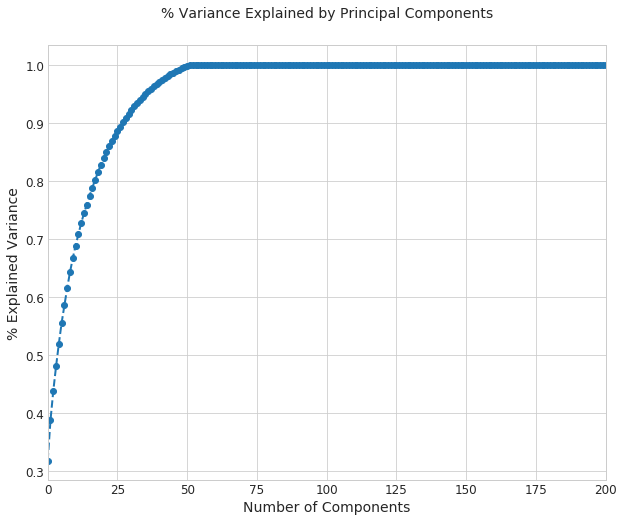

In [106]:
sns.set_style('whitegrid')
pca = PCA(random_state=0)
pca.fit(scaled_X)
plt.figure(1, figsize=(10, 8))
plt.plot(np.cumsum(pca.explained_variance_ratio_),'--o', linewidth=2)
plt.axis('tight')
plt.xlabel('Number of Components',size=14)
plt.xticks(size=12)
plt.xlim([0,200])
plt.ylabel('% Explained Variance',size=14)
plt.yticks(size=12)
plt.title('% Variance Explained by Principal Components',size=14,y=1.05)
plt.show()

In [107]:
pca=PCA(n_components=50,whiten=True,random_state=0)
X_pca_21=pca.fit_transform(scaled_X)
print("Variance explained using 50 components is:",sum(pca.explained_variance_ratio_))

Variance explained using 50 components is: 0.996721136608


In [108]:
print("The train/test split ratio is 80:20")
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_pca_21,y,random_state=0,test_size=0.2)

The train/test split ratio is 80:20


In [109]:
## Table to store training and test measures so we can compare later
table_80_70_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_70_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

In [110]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j]=f[i](X_train,Y_train,X_test,Y_test,np.arange(0,50).astype(str))
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_70_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_70_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc])
    print("\n")

K-Nearest Neighbors
Accuracy of the KNN model for training data is: 0.860459073192
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29542    84    29626
True        4749   260     5009
__all__    34291   344    34635

Accuracy of the KNN model for twst data is: 0.856334449706
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7346    36     7382
True        1208    69     1277
__all__     8554   105     8659



Logistic Regression
Accuracy of the Logistic Regression model for training data is: 0.855348635773
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29607    19    29626
True        4991    18     5009
__all__    34598    37    34635

Accuracy of the Logistic Regression model for twst data is: 0.852407899296
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7377     5     7382
True        1273     4     1277
__all__     8650     9     8659



RandomForest Classifier
Accuracy of the Random Forest Classifier model for training data is: 0.88765699437
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26034  3592    29626
True         299  4710     5009
__all__    26333  8302    34635

Accuracy of the Random Forest Classifier for twst data is: 0.878045963737
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6454   928     7382
True         128  1149     1277
__all__     6582  2077     8659



Adaoost Classifier
Accuracy of the Ada Boost Classifier model for training data is: 0.878186805255
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26070  3556    29626
True         663  4346     5009
__all__    26733  7902    34635

Accuracy of the Ada Boost Classifier for twst data is: 0.872849058783
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6473   909     7382
True         192  1085     1277
__all__     6665  1994     8659



GradientBoosting Classifier
Accuracy of the Gradient Boosting Classifier model for training data is: 0.882864154757
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26070  3556    29626
True         501  4508     5009
__all__    26571  8064    34635

Accuracy of the Gradient Boosting Classifier for twst data is: 0.8772375563
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6470   912     7382
True         151  1126     1277
__all__     6621  2038     8659



ExtraTree Classifier
Accuracy of the Extra Tree Classifier model for training data is: 0.888523170204
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26051  3575    29626
True         286  4723     5009
__all__    26337  8298    34635

Accuracy of the Extra Tree Classifier for twst data is: 0.878161450514
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6453   929     7382
True         126  1151     1277
__all__     6579  2080     8659



Bagging Classifier
Accuracy of the Bagging model for training data is: 0.887454886675
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26053  3573    29626
True         325  4684     5009
__all__    26378  8257    34635

Accuracy of the Bagging model for twst data is: 0.878507910844
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6460   922     7382
True         130  1147     1277
__all__     6590  2069     8659



Neural Network-1
The accuracy of the model on training data is: 0.884683124008


Predicted  False  True  __all__
Actual                         
False      25975  3651    29626
True         343  4666     5009
__all__    26318  8317    34635

The accuracy of the model on test data is: 0.875043307541


Predicted  False  True  __all__
Actual                         
False       6435   947     7382
True         135  1142     1277
__all__     6570  2089     8659

### <a id='3.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [111]:
trace0 = go.Scatter(x=table_80_70_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_70_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_70_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_70_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_70_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_70_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_70_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_70_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [112]:
table_80_70_train['index']=ind_columns
table_80_70_test['index']=ind_columns


table_80_70_test.set_index(['index'],drop=True,inplace=True)
table_80_70_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_70_train)
print("Test Results")
display(table_80_70_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.860459,260.0,29542.0,84.0,4749.0,0.002835,0.948093
LogisticRegression,0.855349,18.0,29607.0,19.0,4991.0,0.000641,0.996406
RandomForestClassifier,0.887657,4710.0,26034.0,3592.0,299.0,0.121245,0.059693
AdaBoostClassifier,0.878187,4346.0,26070.0,3556.0,663.0,0.120030,0.132362
GradientBoostingClassifier,0.882864,4508.0,26070.0,3556.0,501.0,0.120030,0.100020
ExtraTreeClassifier,0.888523,4723.0,26051.0,3575.0,286.0,0.120671,0.057097
BaggingClassifier,0.887455,4684.0,26053.0,3573.0,325.0,0.120604,0.064883
Neural Network-1,0.884683,4666.0,25975.0,3651.0,343.0,0.123236,0.068477


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
KNeighborsClassifier,0.856334,69.0,7346.0,36.0,1208.0,0.004877,0.945967,0.524578
LogisticRegression,0.852408,4.0,7377.0,5.0,1273.0,0.000677,0.996868,0.501228
RandomForestClassifier,0.878046,1149.0,6454.0,928.0,128.0,0.125711,0.100235,0.887027
AdaBoostClassifier,0.872849,1085.0,6473.0,909.0,192.0,0.123137,0.150352,0.863255
GradientBoostingClassifier,0.877238,1126.0,6470.0,912.0,151.0,0.123544,0.118246,0.879105
ExtraTreeClassifier,0.878161,1151.0,6453.0,929.0,126.0,0.125847,0.098669,0.887742
BaggingClassifier,0.878508,1147.0,6460.0,922.0,130.0,0.124898,0.101801,0.886650
Neural Network-1,0.875043,1142.0,6435.0,947.0,135.0,0.128285,0.105717,0.886650


### <a id='3.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [113]:
feat_impt_plot(np.average(feat_imp,axis=0),np.arange(0,50).astype(str))

### <a id='4' style="text-decoration : none; color : #000000;"> 5. Over Sampling</a>

In [114]:
columns=col_values[col_values['95_%_same_values']==False].index.values
print('Features we will be using:\n')
display(columns.tolist())

Features we will be using:



['dom_function_document.createElement(',
 'dom_function_document.getElementById(',
 'dom_function_document.getElementsByTagName(',
 'dom_function_document.querySelector(',
 'dom_function_document.write(',
 'dom_function_window.addEventListener(',
 'dom_function_window.open(',
 'dom_function_window.setTimeout(',
 'js_function_.add(',
 'js_function_.apply(',
 'js_function_.bind(',
 'js_function_.call(',
 'js_function_.charAt(',
 'js_function_.concat(',
 'js_function_.defineProperty(',
 'js_function_.exec(',
 'js_function_.find(',
 'js_function_.forEach(',
 'js_function_.get(',
 'js_function_.getTime(',
 'js_function_.hasOwnProperty(',
 'js_function_.indexOf(',
 'js_function_.join(',
 'js_function_.keys(',
 'js_function_.log(',
 'js_function_.match(',
 'js_function_.pop(',
 'js_function_.push(',
 'js_function_.replace(',
 'js_function_.setTime(',
 'js_function_.shift(',
 'js_function_.slice(',
 'js_function_.split(',
 'js_function_.substring(',
 'js_function_.test(',
 'js_function_.toLowe

In [115]:
### Preparing our training and test sets
X=df[columns].values
y=df.Target.values

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)

sm = SMOTE(random_state=12, ratio = 1.0)
X_train, Y_train = sm.fit_sample(X_train, Y_train)

The train/test split ratio is 80:20


In [116]:
## Table to store training and test measures so we can compare later
table_80_80_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_80_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

In [117]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j]=f[i](X_train,Y_train,X_test,Y_test,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_80_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_80_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc])
    print("\n")

K-Nearest Neighbors
Accuracy of the KNN model for training data is: 0.904084388186
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      25692   3933    29625
True        1750  27875    29625
__all__    27442  31808    59250

Accuracy of the KNN model for twst data is: 0.868922508373
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6370  1013     7383
True         122  1154     1276
__all__     6492  2167     8659



Logistic Regression
Accuracy of the Logistic Regression model for training data is: 0.854514767932
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      23078   6547    29625
True        2073  27552    29625
__all__    25151  34099    59250

Accuracy of the Logistic Regression model for twst data is: 0.796512299342
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       5725  1658     7383
True         104  1172     1276
__all__     5829  2830     8659



RandomForest Classifier
Accuracy of the Random Forest Classifier model for training data is: 0.923358649789
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      25547   4078    29625
True         463  29162    29625
__all__    26010  33240    59250

Accuracy of the Random Forest Classifier for twst data is: 0.869846402587
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6335  1048     7383
True          79  1197     1276
__all__     6414  2245     8659



Adaoost Classifier
Accuracy of the Ada Boost Classifier model for training data is: 0.872455696203
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      25227   4398    29625
True        3159  26466    29625
__all__    28386  30864    59250

Accuracy of the Ada Boost Classifier for twst data is: 0.856449936482
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6303  1080     7383
True         163  1113     1276
__all__     6466  2193     8659



GradientBoosting Classifier
Accuracy of the Gradient Boosting Classifier model for training data is: 0.898886075949
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      25123   4502    29625
True        1489  28136    29625
__all__    26612  32638    59250

Accuracy of the Gradient Boosting Classifier for twst data is: 0.857373830696
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6254  1129     7383
True         106  1170     1276
__all__     6360  2299     8659



ExtraTree Classifier
Accuracy of the Extra Tree Classifier model for training data is: 0.923797468354
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      25557   4068    29625
True         447  29178    29625
__all__    26004  33246    59250

Accuracy of the Extra Tree Classifier for twst data is: 0.86938445548
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6334  1049     7383
True          82  1194     1276
__all__     6416  2243     8659



Bagging Classifier
Accuracy of the Bagging model for training data is: 0.922970464135
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      25550   4075    29625
True         489  29136    29625
__all__    26039  33211    59250

Accuracy of the Bagging model for twst data is: 0.868345074489
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6322  1061     7383
True          79  1197     1276
__all__     6401  2258     8659



Neural Network-1
The accuracy of the model on training data is: 0.914362869198


Predicted  False   True  __all__
Actual                          
False      25180   4445    29625
True         629  28996    29625
__all__    25809  33441    59250

The accuracy of the model on test data is: 0.857489317473


Predicted  False  True  __all__
Actual                         
False       6221  1162     7383
True          72  1204     1276
__all__     6293  2366     8659

### <a id='4.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [118]:
trace0 = go.Scatter(x=table_80_80_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_80_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_80_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_80_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_80_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_80_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_80_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_80_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [119]:
table_80_80_train['index']=ind_columns
table_80_80_test['index']=ind_columns


table_80_80_test.set_index(['index'],drop=True,inplace=True)
table_80_80_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_80_train)
print("Test Results")
display(table_80_80_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.904084,27875.0,25692.0,3933.0,1750.0,0.132759,0.059072
LogisticRegression,0.854515,27552.0,23078.0,6547.0,2073.0,0.220996,0.069975
RandomForestClassifier,0.923359,29162.0,25547.0,4078.0,463.0,0.137654,0.015629
AdaBoostClassifier,0.872456,26466.0,25227.0,4398.0,3159.0,0.148456,0.106633
GradientBoostingClassifier,0.898886,28136.0,25123.0,4502.0,1489.0,0.151966,0.050262
ExtraTreeClassifier,0.923797,29178.0,25557.0,4068.0,447.0,0.137316,0.015089
BaggingClassifier,0.922970,29136.0,25550.0,4075.0,489.0,0.137553,0.016506
Neural Network-1,0.914363,28996.0,25180.0,4445.0,629.0,0.150042,0.021232


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
KNeighborsClassifier,0.868923,1154.0,6370.0,1013.0,122.0,0.137207,0.095611,0.883591
LogisticRegression,0.796512,1172.0,5725.0,1658.0,104.0,0.224570,0.081505,0.846963
RandomForestClassifier,0.869846,1197.0,6335.0,1048.0,79.0,0.141948,0.061912,0.898070
AdaBoostClassifier,0.856450,1113.0,6303.0,1080.0,163.0,0.146282,0.127743,0.862988
GradientBoostingClassifier,0.857374,1170.0,6254.0,1129.0,106.0,0.152919,0.083072,0.882005
ExtraTreeClassifier,0.869384,1194.0,6334.0,1049.0,82.0,0.142083,0.064263,0.896827
BaggingClassifier,0.868345,1197.0,6322.0,1061.0,79.0,0.143709,0.061912,0.897190
Neural Network-1,0.857489,1204.0,6221.0,1162.0,72.0,0.157389,0.056426,0.897190


### <a id='4.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [120]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='5' style="text-decoration : none; color : #000000;"> 6. Under Sampling</a>

In [121]:
df_non=df[df.Target==0]
df_mal=df[df.Target==1]

df_non=df_non.sample(frac=len(df_mal)/len(df_non),random_state=0)
df_u=df_non.append(df_mal)
df_u.Target.value_counts() 

X=df_u[columns]
y=df_u.Target.values

feature_name = X.columns.tolist()
print("Shape after undersampling",df_u.shape)
df_u.head()

Shape after undersampling (12572, 287)


,dom_function_document.captureEvents(,dom_function_document.close(,dom_function_document.createAttribute(,dom_function_document.createComment(,dom_function_document.createDocumentFragment(,dom_function_document.createElement(,dom_function_document.createElementNS(,dom_function_document.createEvent(,dom_function_document.createNodeIterator(,dom_function_document.createProcessingInstruction(,dom_function_document.createRange(,dom_function_document.createTextNode(,dom_function_document.createTreeWalker(,dom_function_document.elementFromPoint(,dom_function_document.elementsFromPoint(,dom_function_document.execCommand(,dom_function_document.getElementById(,dom_function_document.getElementsByClassName(,dom_function_document.getElementsByTagName(,dom_function_document.getSelection(,dom_function_document.hasFocus(,dom_function_document.importNode(,dom_function_document.open(,dom_function_document.queryCommandEnabled(,dom_function_document.querySelector(,dom_function_document.querySelectorAll(,dom_function_document.write(,dom_function_document.writeln(,dom_function_window.addEventListener(,dom_function_window.alert(,dom_function_window.atob(,dom_function_window.blur(,dom_function_window.btoa(,dom_function_window.cancelAnimationFrame(,dom_function_window.captureEvents(,dom_function_window.clearImmediate(,dom_function_window.clearInterval(,dom_function_window.clearTimeout(,dom_function_window.close(,dom_function_window.confirm(,dom_function_window.dispatchEvent(,dom_function_window.fetch(,dom_function_window.find(,dom_function_window.focus(,dom_function_window.getComputedStyle(,dom_function_window.getSelection(,dom_function_window.matchMedia(,dom_function_window.moveTo(,dom_function_window.open(,dom_function_window.postMessage(,dom_function_window.print(,dom_function_window.prompt(,dom_function_window.removeEventListener(,dom_function_window.requestAnimationFrame(,dom_function_window.resizeBy(,dom_function_window.resizeTo(,dom_function_window.scroll(,dom_function_window.scrollBy(,dom_function_window.scrollTo(,dom_function_window.setImmediate(,dom_function_window.setInterval(,dom_function_window.setTimeout(,dom_function_window.stop(,js_function_.add(,js_function_.all(,js_function_.anchor(,js_function_.apply(,js_function_.bind(,js_function_.blink(,js_function_.bold(,js_function_.call(,js_function_.catch(,js_function_.charAt(,js_function_.charCodeAt(,js_function_.clear(,js_function_.codePointAt(,js_function_.compile(,js_function_.concat(,js_function_.construct(,js_function_.defineProperty(,js_function_.delete(,js_function_.deleteProperty(,js_function_.endWith(,js_function_.entries(,js_function_.every(,js_function_.exec(,js_function_.fill(,js_function_.filter(,js_function_.find(,js_function_.findIndex(,js_function_.flatMap(,js_function_.fontcolor(,js_function_.forEach(,js_function_.from(,js_function_.get(,js_function_.getDate(,js_function_.getDay(,js_function_.getFullYear(,js_function_.getHours(,js_function_.getInt16(,js_function_.getInt32(,js_function_.getInt8(,js_function_.getMilliseconds(,js_function_.getMinutes(,js_function_.getMonth(,js_function_.getOwnPropertyDescriptor(,js_function_.getPrototypeOf(,js_function_.getSeconds(,js_function_.getTime(,js_function_.getTimezoneOffset(,js_function_.getUTCDate(,js_function_.getUTCDay(,js_function_.getUTCFullYear(,js_function_.getUTCHours(,js_function_.getUTCMilliseconds(,js_function_.getUTCMinutes(,js_function_.getUTCMonth(,js_function_.getUTCSeconds(,js_function_.getUint16(,js_function_.getUint32(,js_function_.getUint8(,js_function_.getYear(,js_function_.has(,js_function_.hasOwnProperty(,js_function_.includes(,js_function_.indexOf(,js_function_.isExtensible(,js_function_.isPrototypeOf(,js_function_.italics(,js_function_.join(,js_function_.keys(,js_function_.lastIndexOf(,js_function_.link(,js_function_.localeCompare(,js_function_.log(,js_function_.map(,js_function_.match(,js_function_.min(,js_function_.next(,js_function_.normalize(,js_function_.of(,js_function_.ownKeys(,js_function_.padEnd(,js_f

In [122]:
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)


The train/test split ratio is 80:20


In [123]:
## Table to store training and test measures so we can compare later
table_80_90_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_90_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

In [124]:
print('Features we will be using:\n')
display(columns.tolist())

Features we will be using:



['dom_function_document.createElement(',
 'dom_function_document.getElementById(',
 'dom_function_document.getElementsByTagName(',
 'dom_function_document.querySelector(',
 'dom_function_document.write(',
 'dom_function_window.addEventListener(',
 'dom_function_window.open(',
 'dom_function_window.setTimeout(',
 'js_function_.add(',
 'js_function_.apply(',
 'js_function_.bind(',
 'js_function_.call(',
 'js_function_.charAt(',
 'js_function_.concat(',
 'js_function_.defineProperty(',
 'js_function_.exec(',
 'js_function_.find(',
 'js_function_.forEach(',
 'js_function_.get(',
 'js_function_.getTime(',
 'js_function_.hasOwnProperty(',
 'js_function_.indexOf(',
 'js_function_.join(',
 'js_function_.keys(',
 'js_function_.log(',
 'js_function_.match(',
 'js_function_.pop(',
 'js_function_.push(',
 'js_function_.replace(',
 'js_function_.setTime(',
 'js_function_.shift(',
 'js_function_.slice(',
 'js_function_.split(',
 'js_function_.substring(',
 'js_function_.test(',
 'js_function_.toLowe

In [125]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j]=f[i](X_train,Y_train,X_test,Y_test,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_90_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_90_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc])
    print("\n")

K-Nearest Neighbors
Accuracy of the KNN model for training data is: 0.895893407577
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4252   798     5050
True         249  4758     5007
__all__     4501  5556    10057

Accuracy of the KNN model for twst data is: 0.888667992048
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1043   193     1236
True          87  1192     1279
__all__     1130  1385     2515



Logistic Regression
Accuracy of the Logistic Regression model for training data is: 0.853037685194
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       3922  1128     5050
True         350  4657     5007
__all__     4272  5785    10057

Accuracy of the Logistic Regression model for twst data is: 0.848111332008
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        965   271     1236
True         111  1168     1279
__all__     1076  1439     2515



RandomForest Classifier
Accuracy of the Random Forest Classifier model for training data is: 0.916277219847
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4334   716     5050
True         126  4881     5007
__all__     4460  5597    10057

Accuracy of the Random Forest Classifier for twst data is: 0.89662027833
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1059   177     1236
True          83  1196     1279
__all__     1142  1373     2515



Adaoost Classifier
Accuracy of the Ada Boost Classifier model for training data is: 0.868648702396
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4290   760     5050
True         561  4446     5007
__all__     4851  5206    10057

Accuracy of the Ada Boost Classifier for twst data is: 0.858846918489
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1049   187     1236
True         168  1111     1279
__all__     1217  1298     2515



GradientBoosting Classifier
Accuracy of the Gradient Boosting Classifier model for training data is: 0.886844983594
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4257   793     5050
True         345  4662     5007
__all__     4602  5455    10057

Accuracy of the Gradient Boosting Classifier for twst data is: 0.881510934394
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1048   188     1236
True         110  1169     1279
__all__     1158  1357     2515



ExtraTree Classifier
Accuracy of the Extra Tree Classifier model for training data is: 0.919061350303
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4309   741     5050
True          73  4934     5007
__all__     4382  5675    10057

Accuracy of the Extra Tree Classifier for twst data is: 0.896222664016
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1047   189     1236
True          72  1207     1279
__all__     1119  1396     2515



Bagging Classifier
Accuracy of the Bagging model for training data is: 0.916973252461
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4302   748     5050
True          87  4920     5007
__all__     4389  5668    10057

Accuracy of the Bagging model for twst data is: 0.893836978131
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1041   195     1236
True          72  1207     1279
__all__     1113  1402     2515



Neural Network-1
The accuracy of the model on training data is: 0.910211792787


Predicted  False  True  __all__
Actual                         
False       4262   788     5050
True         115  4892     5007
__all__     4377  5680    10057

The accuracy of the model on test data is: 0.891451292247


Predicted  False  True  __all__
Actual                         
False       1030   206     1236
True          67  1212     1279
__all__     1097  1418     2515

### <a id='5.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [126]:
trace0 = go.Scatter(x=table_80_90_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_90_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_90_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_90_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_90_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_90_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_90_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_90_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [127]:
table_80_90_train['index']=ind_columns
table_80_90_test['index']=ind_columns


table_80_90_test.set_index(['index'],drop=True,inplace=True)
table_80_90_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_90_train)
print("Test Results")
display(table_80_90_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.895893,4758.0,4252.0,798.0,249.0,0.158020,0.049730
LogisticRegression,0.853038,4657.0,3922.0,1128.0,350.0,0.223366,0.069902
RandomForestClassifier,0.916277,4881.0,4334.0,716.0,126.0,0.141782,0.025165
AdaBoostClassifier,0.868649,4446.0,4290.0,760.0,561.0,0.150495,0.112043
GradientBoostingClassifier,0.886845,4662.0,4257.0,793.0,345.0,0.157030,0.068904
ExtraTreeClassifier,0.919061,4934.0,4309.0,741.0,73.0,0.146733,0.014580
BaggingClassifier,0.916973,4920.0,4302.0,748.0,87.0,0.148119,0.017376
Neural Network-1,0.910212,4892.0,4262.0,788.0,115.0,0.156040,0.022968


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
KNeighborsClassifier,0.888668,1192.0,1043.0,193.0,87.0,0.156149,0.068022,0.887915
LogisticRegression,0.848111,1168.0,965.0,271.0,111.0,0.219256,0.086787,0.846979
RandomForestClassifier,0.896620,1196.0,1059.0,177.0,83.0,0.143204,0.064894,0.895951
AdaBoostClassifier,0.858847,1111.0,1049.0,187.0,168.0,0.151294,0.131353,0.858676
GradientBoostingClassifier,0.881511,1169.0,1048.0,188.0,110.0,0.152104,0.086005,0.880946
ExtraTreeClassifier,0.896223,1207.0,1047.0,189.0,72.0,0.152913,0.056294,0.895397
BaggingClassifier,0.893837,1207.0,1041.0,195.0,72.0,0.157767,0.056294,0.892970
Neural Network-1,0.891451,1212.0,1030.0,206.0,67.0,0.166667,0.052385,0.892970


### <a id='5.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [128]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

In [129]:
### Original Creator : Darshan Bhansali
### HTML code to hide the input cells 
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle code, click <a href="javascript:code_toggle()">here</a>.''')